# Import JSON Database containing 5SS mechanisms

In [1]:
import json
with open('database5SS.txt') as f:
    json_data = json.load(f)
#print(json.dumps(json_data, indent=4))

# Create numpy arrays for data

In [2]:
import numpy as np

MechList=[];
CplrPathList=[];
for d in json_data:
    MechList.append(np.asarray(d["Mech"]))
    CplrPathList.append(np.asarray(d["CplrPath"]))

# Plot sample Coupler curve data

In [3]:
#%matplotlib inline
%matplotlib notebook

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from IPython import display
from numpy import linalg as LA


def plotPath(Pts, ax, limit, color = 'gray'):
    xline=Pts[:,0]
    yline=Pts[:,1]
    zline=Pts[:,2]
    ax.plot3D(xline, yline, zline, color)
    ax.auto_scale_xyz([-limit, limit], [-limit, limit], [-limit, limit])

def plotXYZ(center, RotMat, ax):
    C=np.vstack((center,center,center))
    R=RotMat
    r=(1,0,0)
    g=(0,1,0)
    b=(0,0,1)
    ax.quiver(C[:,0], C[:,1], C[:,2], R[:,0], R[:,1], R[:,2],color=(r,g,b,r,r,g,g,b,b))

<IPython.core.display.Javascript object>


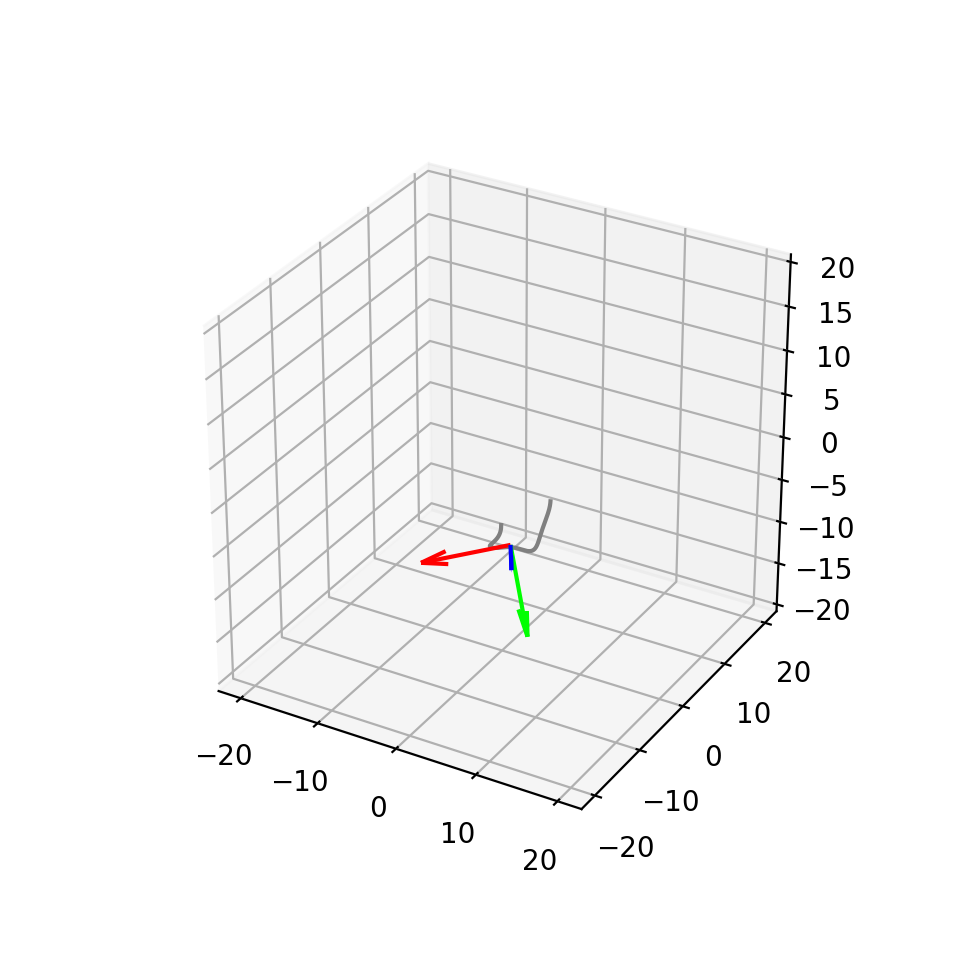

In [4]:
Pts=CplrPathList[21]
fig = plt.figure(figsize=1*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plotPath(Pts, ax, 20)
        
C=np.mean(Pts,axis=0)
Covariance_Mat=np.cov(Pts,rowvar=0)
sing_vec=LA.svd(Covariance_Mat)[0]
R=sing_vec.T*10
plotXYZ(C, R, ax)

<IPython.core.display.Javascript object>


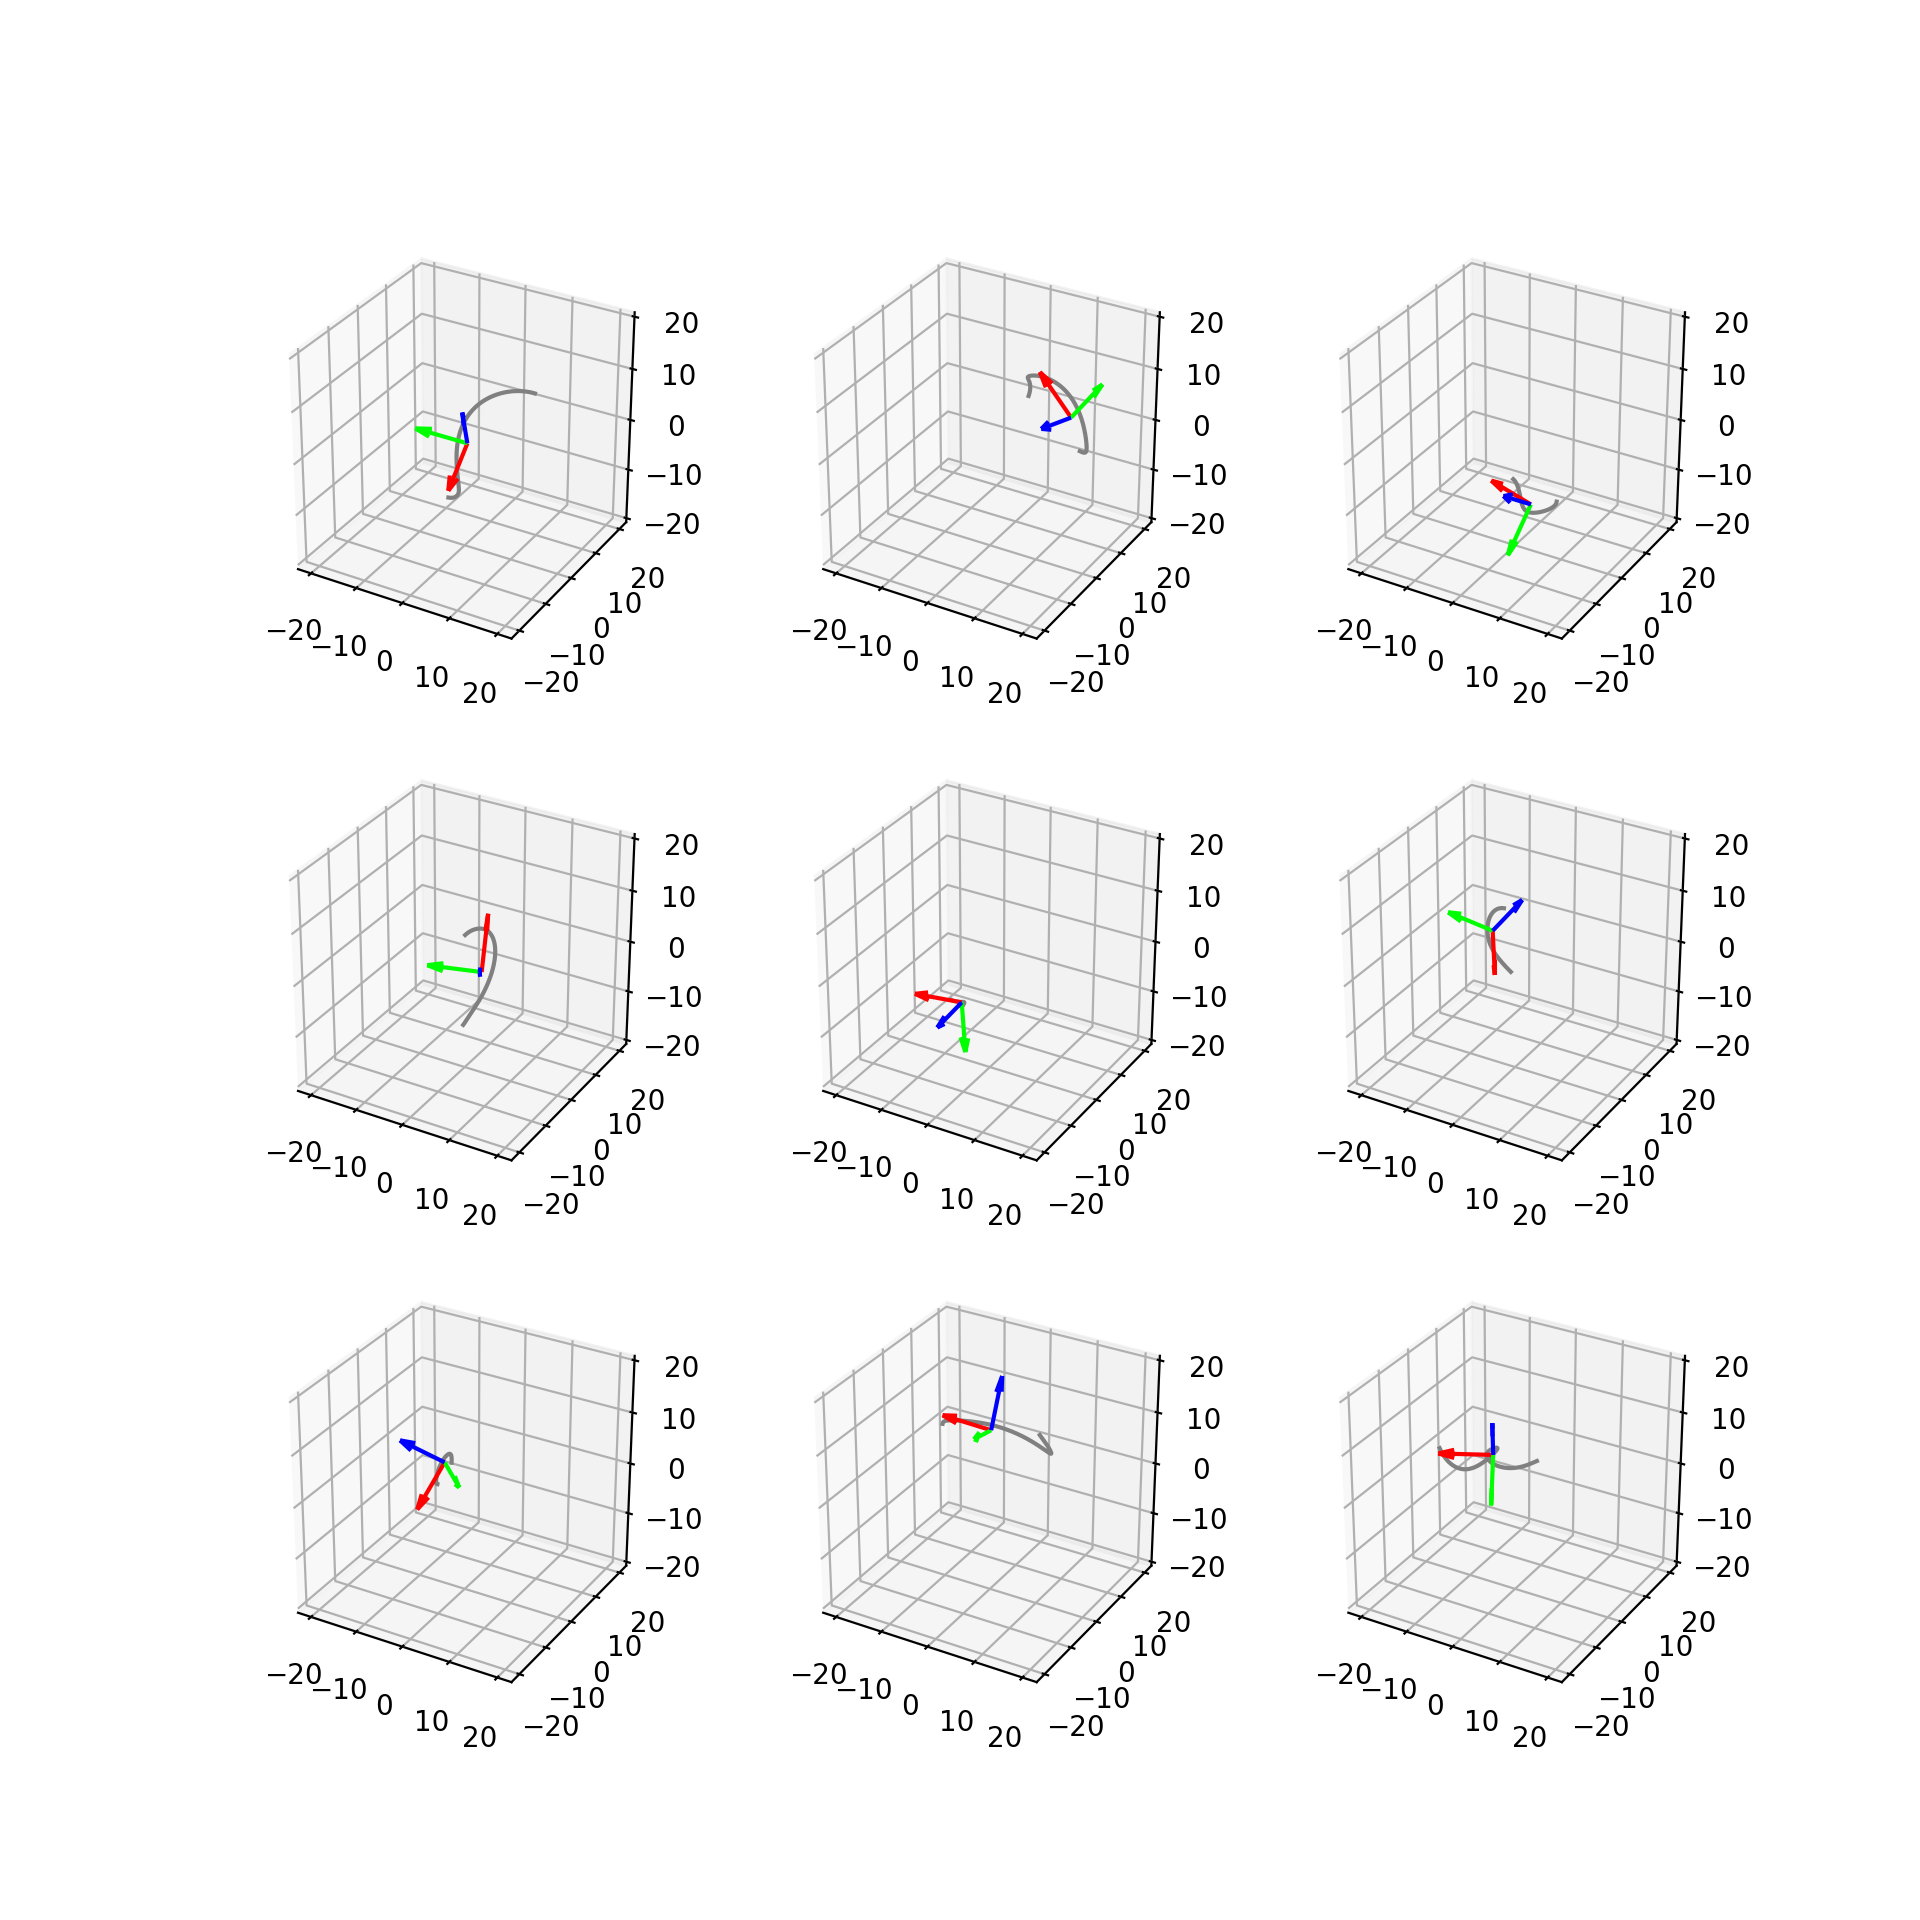

In [5]:
rows=3
cols=3

path_index=0;
fig = plt.figure(figsize=2*plt.figaspect(cols/rows))
for i in range(rows):
    for j in range(cols):
        Pts=CplrPathList[path_index]
        path_index=path_index+1
        ax = fig.add_subplot(cols, rows, path_index, projection='3d')
        plotPath(Pts, ax, 20)
        
        C=np.mean(Pts,axis=0)
        Covariance_Mat=np.cov(Pts,rowvar=0)
        sing_vec=LA.svd(Covariance_Mat)[0]
        R=sing_vec.T*10
        plotXYZ(C, R, ax)

# Remove Coupler paths with too less data

As can be seen in the histogram, the number of points in each coupler path ranges from 2 to 2967 points. We ignore paths having less than 10 datapoints

<IPython.core.display.Javascript object>


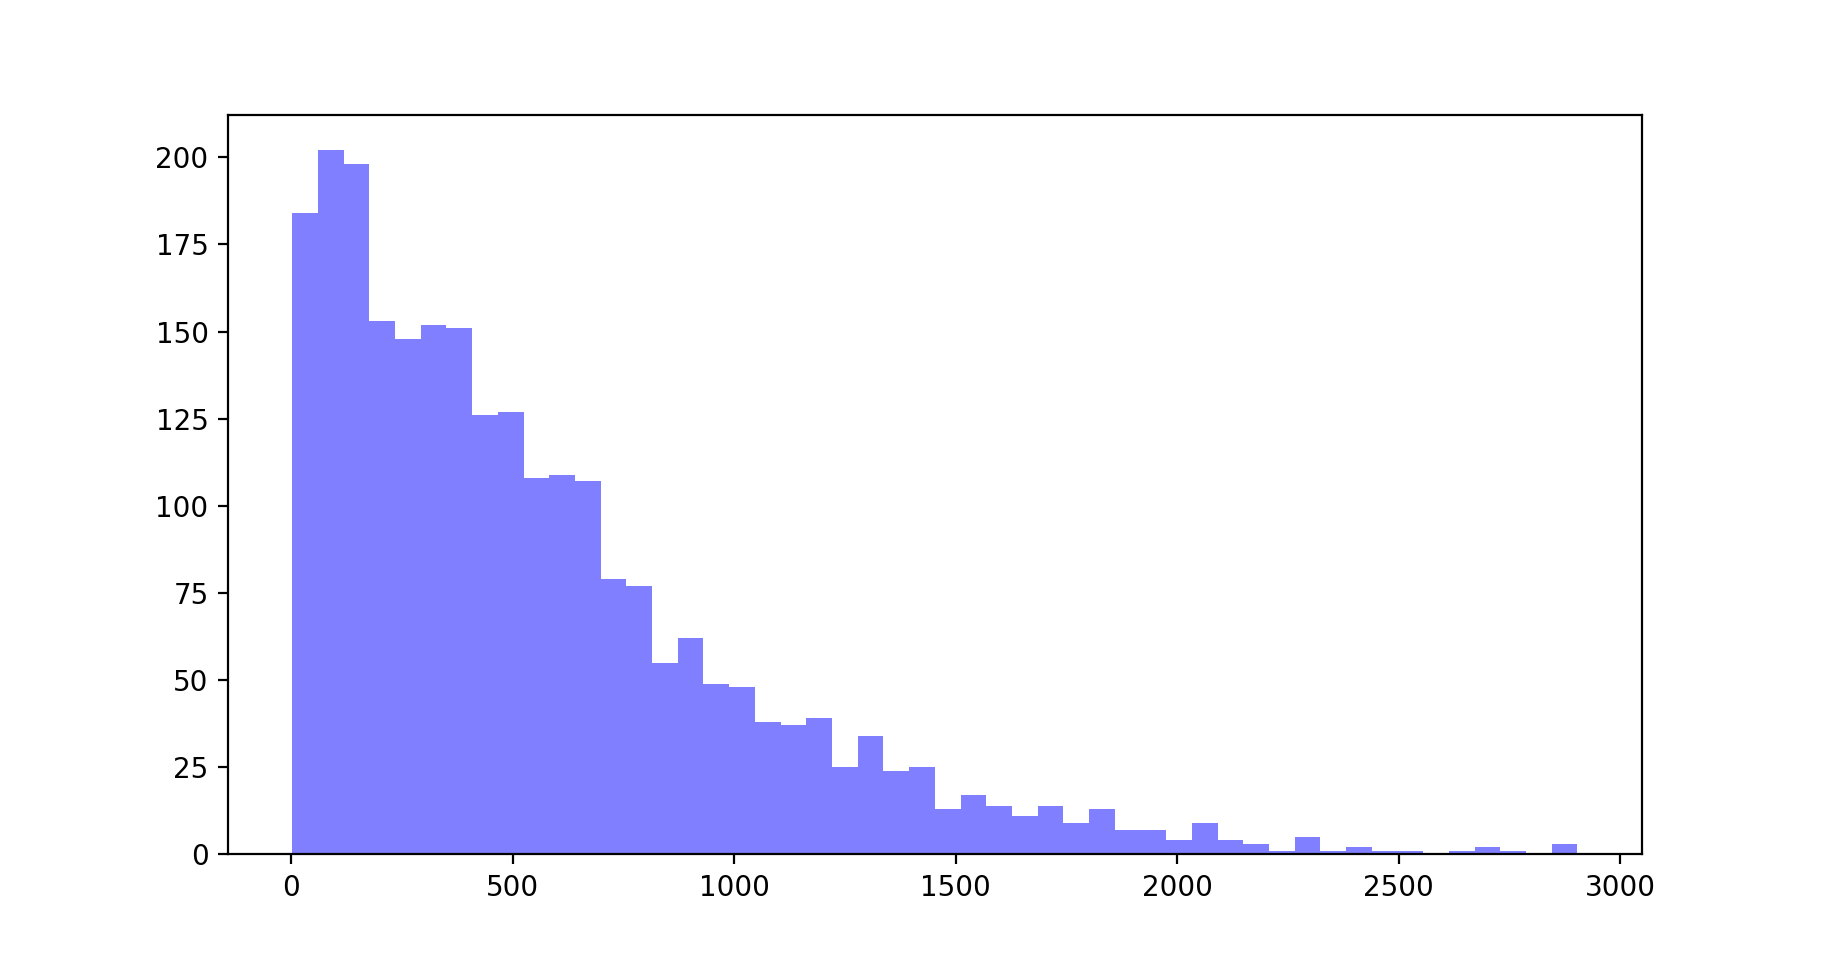

The minimum number of points in a coupler curve are: 2
The maximum number of points in a coupler curve are: 2903


In [6]:
no_Path_Pts=[];
for i in range(len(CplrPathList)):
    no_Path_Pts.append(CplrPathList[i].shape[0])

fig = plt.figure(figsize=1*plt.figaspect(1/1.9))
n, bins, patches = plt.hist(no_Path_Pts, 50, facecolor='blue', alpha=0.5)
plt.show()

print("The minimum number of points in a coupler curve are: "+ str(min(no_Path_Pts)))
print("The maximum number of points in a coupler curve are: "+ str(max(no_Path_Pts)))

In [7]:
# Remove Data with less than 10 points due to too less curve data
print("Database size before removing data: " + str(len(CplrPathList)))
no_Path_Pts=np.array(no_Path_Pts)
leq10_index=np.where(no_Path_Pts<10)

CplrPathList=np.delete(CplrPathList, leq10_index)
MechList=np.delete(MechList, leq10_index, axis=0)
print("Database size after removing data: " + str(len(CplrPathList)))

print(np.array(MechList).shape)
print(np.array(CplrPathList).shape)

Database size before removing data: 2500
Database size after removing data: 2471
(2471, 11, 3)
(2471,)


# Normalize number of points in each path to 100 pts using B-spline curves

To use it in a ML framework, we resample each curve and normalize them to contain 100 points each.

In [8]:
from scipy import interpolate

def normalizePathPts(Path, num_pts=100):
    xp=Path[:,0]
    yp=Path[:,1]
    zp=Path[:,2]
    
    # Check for duplicate points as interpolation routine errors out
    okay = np.where(np.abs(np.diff(xp)) + np.abs(np.diff(yp)) + np.abs(np.diff(zp)) > 0)
    xp = np.r_[xp[okay], xp[-1]]
    yp = np.r_[yp[okay], yp[-1]]
    zp = np.r_[zp[okay], zp[-1]]

    # Fit cubic B-spline to the data points
    tck, u =interpolate.splprep([xp,yp,zp],s=.01)
    u_fine = np.linspace(0,1,num_pts)
    x_100, y_100, z_100 = interpolate.splev(u_fine, tck)
    Path_100 = np.vstack(([x_100],[y_100],[z_100])).T
    
    return Path_100

<IPython.core.display.Javascript object>


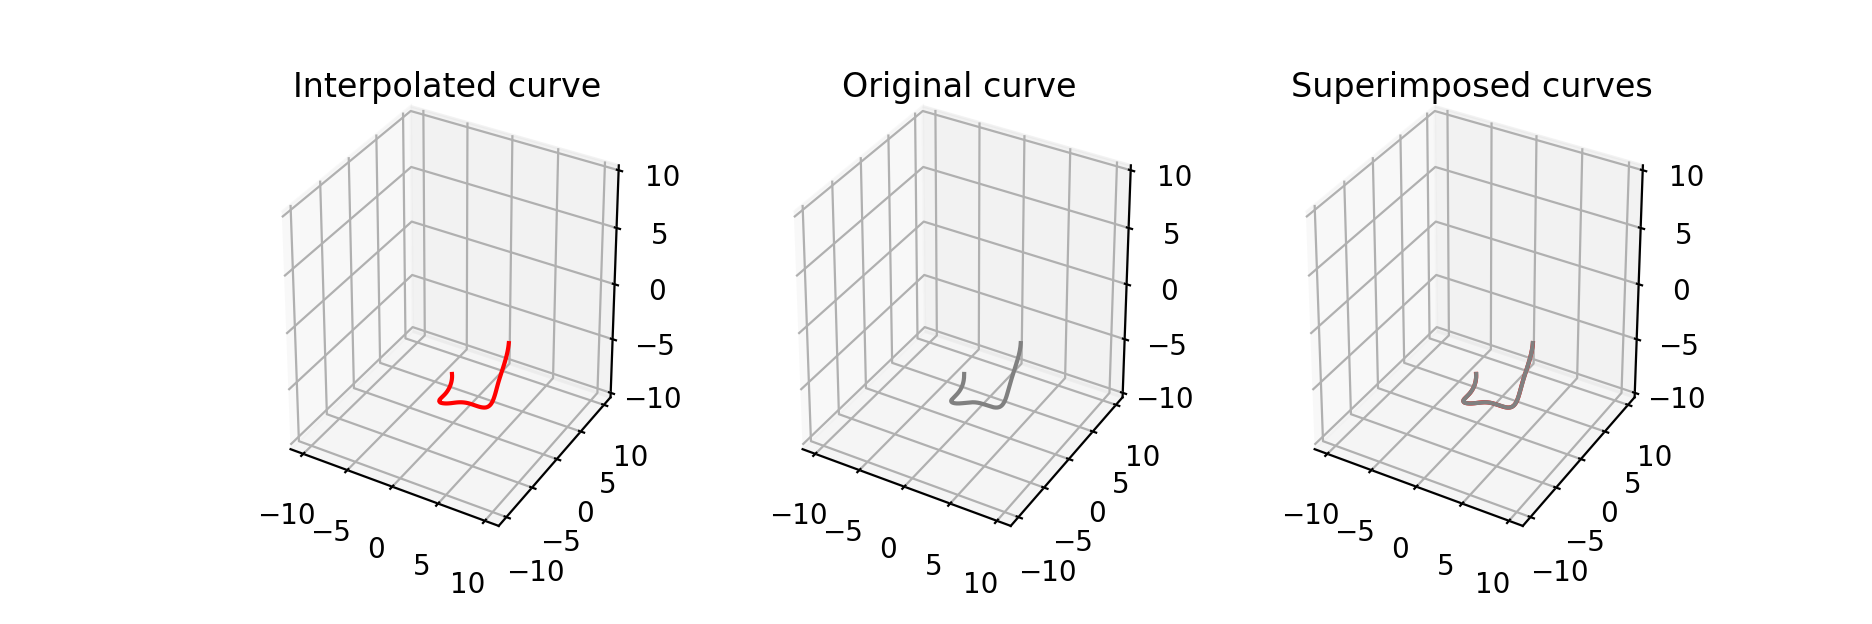

In [9]:
# Visualize how well the fitted curve reflects original data

Path=CplrPathList[21]
Path_100=normalizePathPts(Path)

fig = plt.figure(figsize=.65*plt.figaspect(1/3))
ax = fig.add_subplot(1, 3, 1, projection='3d')
plt.title("Interpolated curve")
plotPath(Path_100, ax, 10, color='r')
ax = fig.add_subplot(1, 3, 2, projection='3d')
plt.title("Original curve")
plotPath(Path, ax, 10, color='grey')
ax = fig.add_subplot(1, 3, 3, projection='3d')
plt.title("Superimposed curves")
plotPath(Path_100, ax, 10, color='r')
plotPath(Path, ax, 10, color='grey')

In [10]:
MechList100=MechList;
CplrPathList100=[];

for i in range(len(CplrPathList)):
    Path=CplrPathList[i]
    Path_100=normalizePathPts(Path)
    CplrPathList100.append(Path_100)

# Normalize Data (Translation,Rotation, Scaling)

- Translation: Average of all points moved to origin.
- Rotation: Principal axes rotated to align with x-axis
- Scaling: Divide points by maximum standard deviation

In [11]:
def normalizePath(Path):
    #TRANSLATION
    T=np.mean(Path,axis=0)
    Trans_Path=Path-T

    #ROTATION
    Covariance_Mat=np.cov(Trans_Path,rowvar=0)
    sing_vec=LA.svd(Covariance_Mat)[0]
    R=sing_vec.T
    Rot_Path=np.matmul(R,Trans_Path.T).T
    
    #SCALING
    S=np.max(np.std(Rot_Path,axis=0))
    Scale_Path=Rot_Path/S

    return Scale_Path, T, R, S

def normalizeMech(Mech, Translate, Rotate, Scale):
    Trans_Mech=Mech-Translate
    Rot_Mech=np.matmul(Rotate,Trans_Mech.T).T
    Scale_Mech=Rot_Mech/Scale
    return Scale_Mech

In [12]:
Norm100MechList=[];
Norm100CplrPathList=[];

for i in range(len(CplrPathList)):
    Path=CplrPathList100[i]
    Mech=MechList100[i]
    
    nPath, T, R, S=normalizePath(Path)
    nMech=normalizeMech(Mech, T, R, S)
    
    Norm100MechList.append(nMech)
    Norm100CplrPathList.append(nPath)

<IPython.core.display.Javascript object>


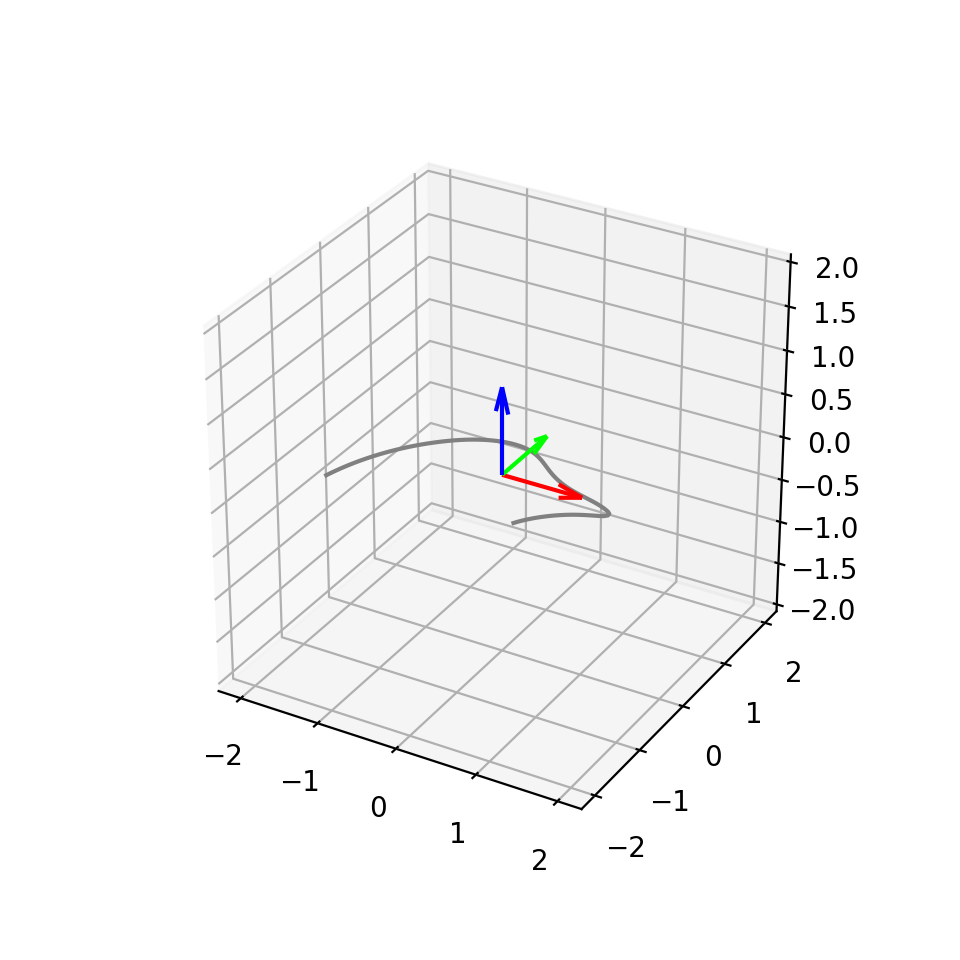

In [13]:
nPath=Norm100CplrPathList[21]

fig = plt.figure(figsize=1*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plotPath(nPath, ax, 2)
plotXYZ(np.zeros((1, 3)), np.identity(3), ax)

# Normalize coordinates in x, y, z axis independently (NOT USED)

Due to our path normalization technique, we orient maximum variance direction with x axis and minimum variance in z axis. This bias leads to the VAE learning X and Y axis data predominanity. Due to this each axis data need to be scaled independently for better fit. However, the aspect ration of the path is not conserved due to this operation and the paths we get are not coupler paths. Thus we ignore this operation

In [14]:
def scalePath(Path):
    S=np.std(Path,axis=0)
    Scale_Path=[]
    Scale_Path.append(Path[:,0]/S[0])
    Scale_Path.append(Path[:,1]/S[1])
    Scale_Path.append(Path[:,2]/S[2])
    return np.asarray(Scale_Path).T

Skewed100CplrPathList=[];
for i in range(len(Norm100CplrPathList)):
    spath=Norm100CplrPathList[i]
    Skewed100CplrPathList.append(scalePath(spath))

<IPython.core.display.Javascript object>


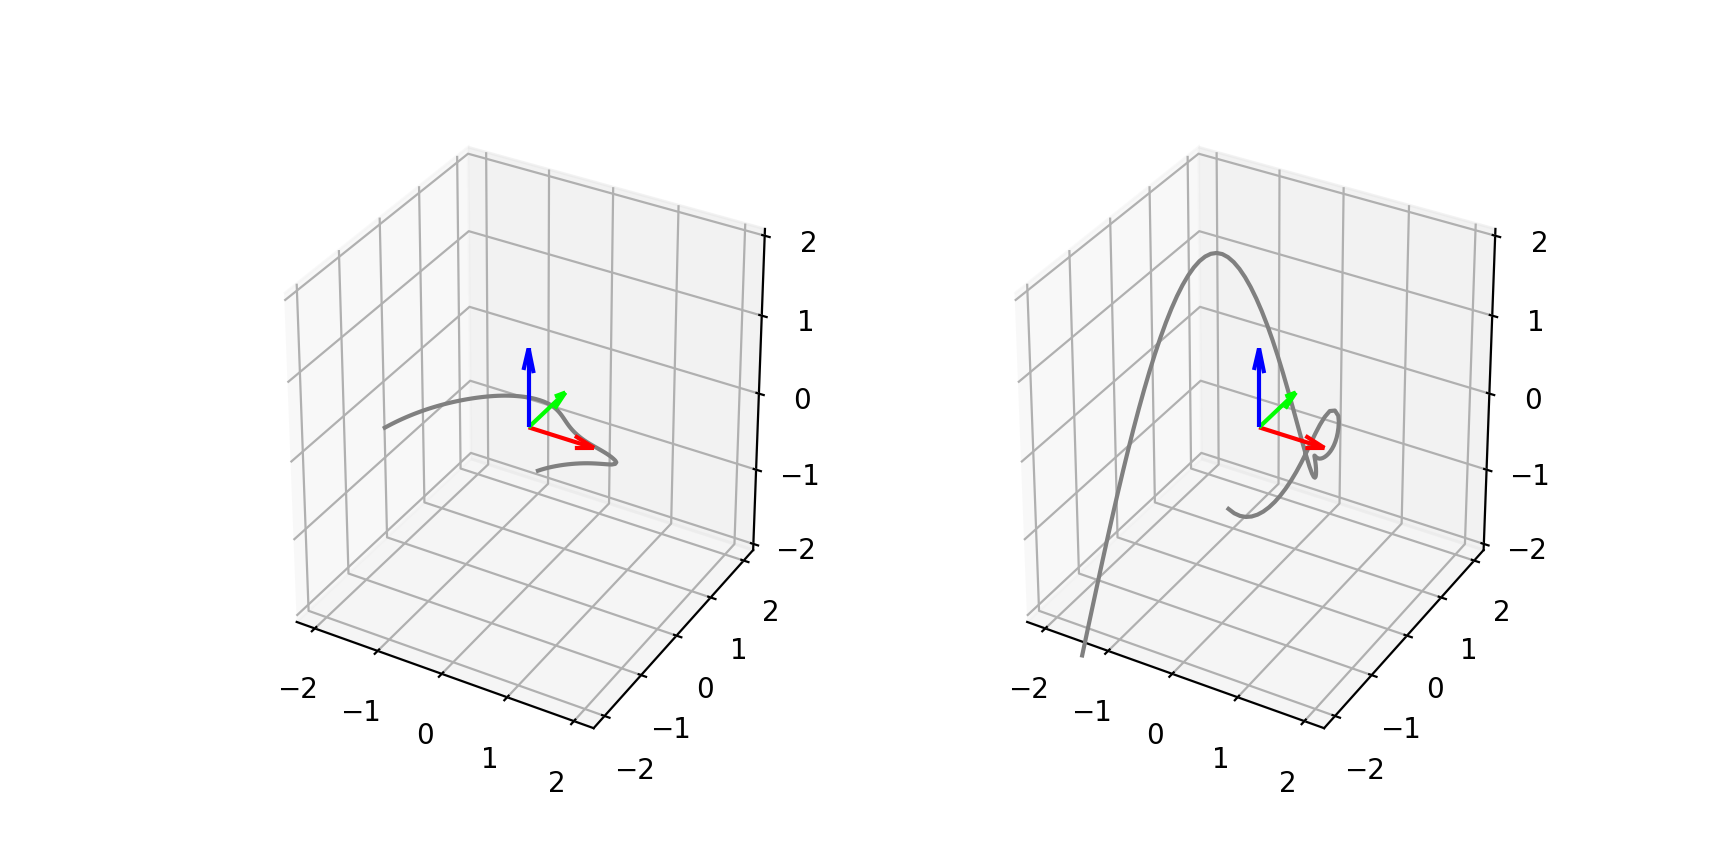

In [15]:
nPath=Norm100CplrPathList[21]
sPath=Skewed100CplrPathList[21]

fig = plt.figure(figsize=.9*plt.figaspect(1/2))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plotPath(nPath, ax, 2)
plotXYZ(np.zeros((1, 3)), np.identity(3), ax)
ax = fig.add_subplot(1, 2, 2, projection='3d')
plotPath(sPath, ax, 2)
plotXYZ(np.zeros((1, 3)), np.identity(3), ax)

# Normalize the variety of data

In its present state, the database has more samples of coupler paths which are more probable while lesser samples of other more diverse. However, we would like our NN to handle all types of coupler paths with same efficiency and accuracy. To overcome this bias, we select a limited number of diverse paths from the complete database. Thus, this new balanced dataset contains equal samples of unique and diverse paths.

In [16]:
normThreshold=.01
DiverseCplrPathList=np.array([Norm100CplrPathList[0]])
DiverseMechList=np.array([Norm100MechList[0]])

for i in range(1,len(Norm100CplrPathList)):
    if i%500==0:
        print(i)
    
    path1=Norm100CplrPathList[i]
    mech1=Norm100MechList[i]
    diff=np.array([])
    
    for path2 in DiverseCplrPathList:
        d=LA.norm(path1-path2)/100
        diff=np.append(diff,[d])
    
    if diff.min()>normThreshold:
        DiverseCplrPathList=np.append(DiverseCplrPathList,[path1], axis=0)
        DiverseMechList=np.append(DiverseMechList,[mech1], axis=0)
        
print("Database size before removing similar paths: " + str(np.array(Norm100CplrPathList).shape[0]))
print("Database size after removing similar paths: " + str(DiverseCplrPathList.shape[0]))

500
1000
1500
2000
Database size before removing similar paths: 2471
Database size after removing similar paths: 1170


<IPython.core.display.Javascript object>


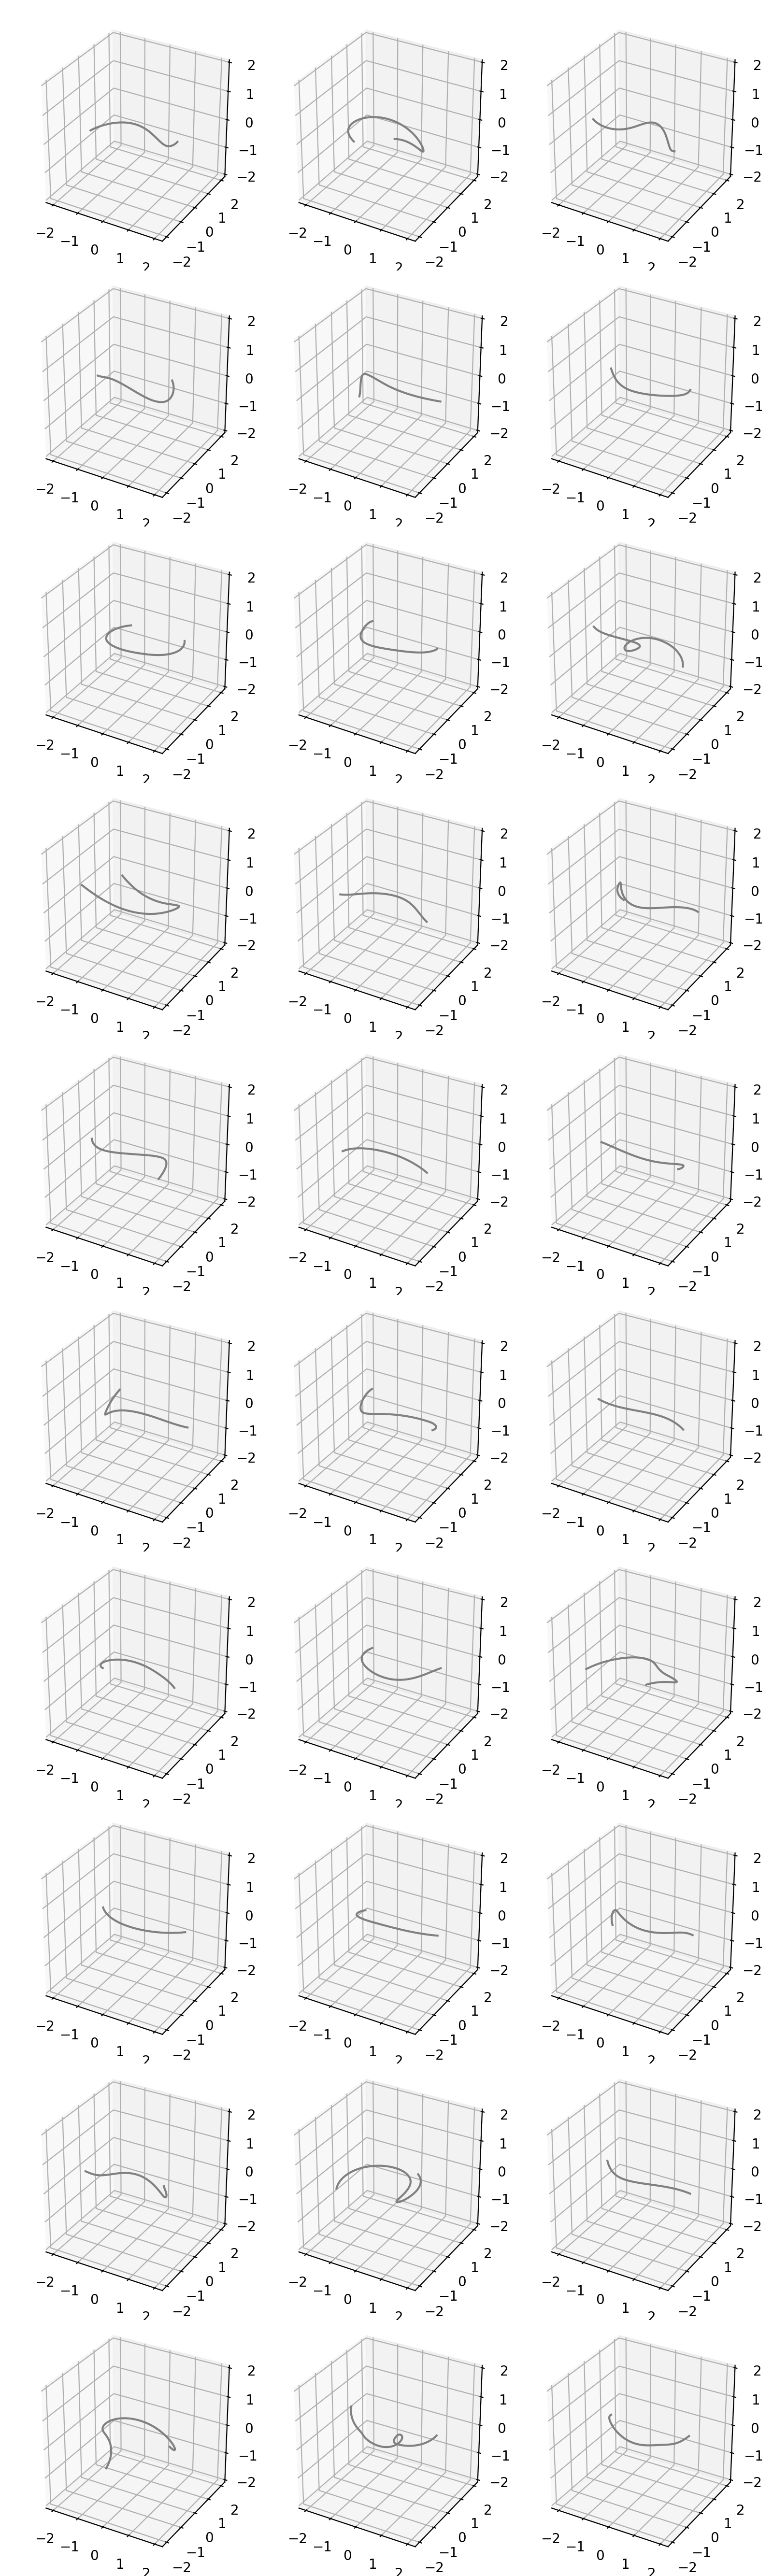

In [17]:
rows=10
cols=3

path_index=0;
fig = plt.figure(figsize=2*plt.figaspect(rows/cols))
for i in range(rows):
    for j in range(cols):
        Pts=DiverseCplrPathList[path_index]
        path_index=path_index+1
        ax = fig.add_subplot(rows, cols, path_index, projection='3d')
        plotPath(Pts, ax, 2)
        #plotXYZ(np.zeros((1, 3)), np.identity(3), ax)
plt.tight_layout()
plt.show()

# Store the Diverse Normalized Database

In [18]:
np.savez('norm_database5SS', cplrData=DiverseCplrPathList, mechData=DiverseMechList) 

In [19]:
db = np.load('norm_database5SS.npz') # loads your saved array into variable a.

In [20]:
db.files

['cplrData', 'mechData']

In [21]:
print(db['cplrData'].shape)
print(db['mechData'].shape)

(1170, 100, 3)
(1170, 11, 3)
